In [1]:
# Key components of Dynamic Range Control: compression, expansion, limiting, gating
# Compression reduces the dynamic range by lowering the volume of loud sounds
# Expansion increases the dynamic range by raising the volume of quiet sounds
# Limiting prevents the signal from exceeding a certain level
# Gating reduces the volume of sounds below a certain threshold

# Compute dynamic range of an audio wav file 

import numpy as np
from scipy.io.wavfile import read as wav_read

def compute_dynamic_range(file_path):
    # Load the audio file
    sample_rate, audio = wav_read(file_path)
    
    # If stereo, convert to mono
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    
    # Check for invalid values and handle them
    if np.any(np.isnan(audio)) or np.any(np.isinf(audio)):
        audio = np.nan_to_num(audio)  # Replace NaN/Inf with 0
    
    # Compute peak level
    peak_level = np.max(np.abs(audio))
    
    # Compute RMS level
    rms_level = np.sqrt(np.mean(audio**2))
    
    # Avoid division by zero
    if rms_level == 0:
        return float('-inf')  # Dynamic range is undefined if RMS is 0
    
    # Compute dynamic range in dB
    dynamic_range = 20 * np.log10(peak_level / rms_level)
    
    return dynamic_range

# Example usage
file_path = "Data/sine_wave_44100Hz_16bit_1min.wav"
dynamic_range = compute_dynamic_range(file_path)
print(f"Dynamic Range: {dynamic_range:.2f} dB")

Dynamic Range: 66.10 dB


In [ ]:
def compute_snr(file_path):
    from scipy.signal import butter, filtfilt

    # Load the audio file
    sample_rate, audio = wav_read(file_path)

    # If stereo, convert to mono
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)

    # Normalize the audio to range [-1, 1]
    audio = audio / np.max(np.abs(audio))

    # Check for invalid values and handle them
    if np.any(np.isnan(audio)) or np.any(np.isinf(audio)):
        audio = np.nan_to_num(audio)  # Replace NaN/Inf with 0

    # Compute RMS level of the signal
    signal_rms = np.sqrt(np.mean(audio**2))

    # Use a high-pass filter to estimate noise
    def high_pass_filter(data, cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
        return filtfilt(b, a, data)

    # Apply high-pass filter with a cutoff frequency of 500 Hz
    noise = high_pass_filter(audio, cutoff=500, fs=sample_rate)
    noise_rms = np.sqrt(np.mean(noise**2))

    # Avoid division by zero
    if noise_rms == 0:
        return float('inf')  # SNR is infinite if noise is 0

    # Compute SNR in dB
    snr = 20 * np.log10(signal_rms / noise_rms)

    return snr

# Example usage
sine_file_path = "Data/sine_wave_44100Hz_16bit_1min.wav"
music_file_path = "Data/CTHS3_Acid_Bass_Loop_01_C_123.wav"
sine_snr = compute_snr(sine_file_path)
print(f"Sine file SNR: {sine_snr:.2f} dB")
music_snr = compute_snr(music_file_path)
print(f"Music file SNR: {music_snr:.2f} dB")

Sine file SNR: 13.24 dB
Music file SNR: 26.46 dB


/var/folders/b0/m80gf4wx3pvdbp860pz1fqwc0000gn/T/ipykernel_78613/3746785883.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wav_read(file_path)


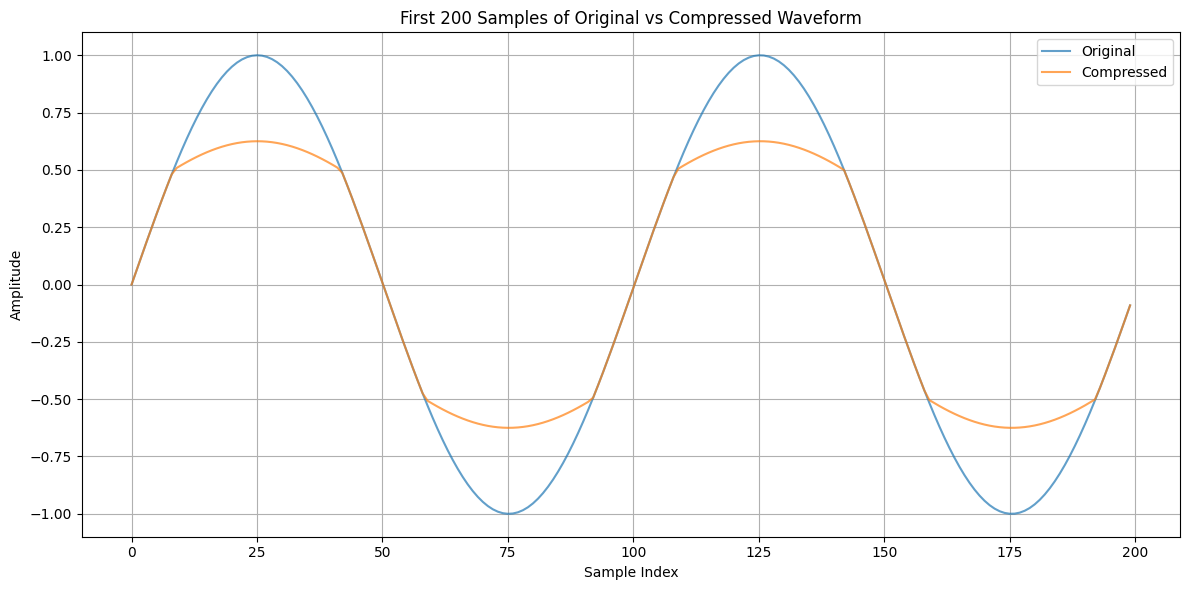

Compressed audio saved to Output/compressed_sine_wave.wav


In [2]:
# Apply compression to th sine wave file
import numpy as np
from scipy.io.wavfile import read as wav_read, write as wav_write
import matplotlib.pyplot as plt

def apply_compression(audio, threshold, ratio):
    """
    Apply dynamic range compression to an audio signal.
    :param audio: Input audio signal (numpy array)
    :param threshold: Threshold level for compression
    :param ratio: Compression ratio
    :return: Compressed audio signal
    """
    compressed_audio = np.copy(audio)
    for i in range(len(audio)):
        if np.abs(audio[i]) > threshold:
            compressed_audio[i] = np.sign(audio[i]) * (
                threshold + (np.abs(audio[i]) - threshold) / ratio
            )
    return compressed_audio

# Load the sine wave file
file_path = "Data/sine_wave_44100Hz_16bit_1min.wav"
sample_rate, audio = wav_read(file_path)

# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

# Normalize the audio to range [-1, 1]
audio = audio / np.max(np.abs(audio))

# Compression parameters
threshold = 0.5  # Threshold level (normalized)
ratio = 4.0      # Compression ratio

# Apply compression
compressed_audio = apply_compression(audio, threshold, ratio)

# Save the compressed audio to a new file
output_file_path = "Output/compressed_sine_wave.wav"
wav_write(output_file_path, sample_rate, (compressed_audio * 32767).astype(np.int16))

# Plot the original and compressed waveforms
# time = np.linspace(0, len(audio) / sample_rate, num=len(audio))
# plt.figure(figsize=(12, 6))
# plt.plot(time, audio, label="Original", alpha=0.7)
# plt.plot(time, compressed_audio, label="Compressed", alpha=0.7)
# plt.title("Original vs Compressed Waveform")
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

# Plot the first 200 samples of the original and compressed audio
plt.figure(figsize=(12, 6))
plt.plot(audio[:200], label="Original", alpha=0.7)
plt.plot(compressed_audio[:200], label="Compressed", alpha=0.7)
plt.title("First 200 Samples of Original vs Compressed Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Compressed audio saved to {output_file_path}")

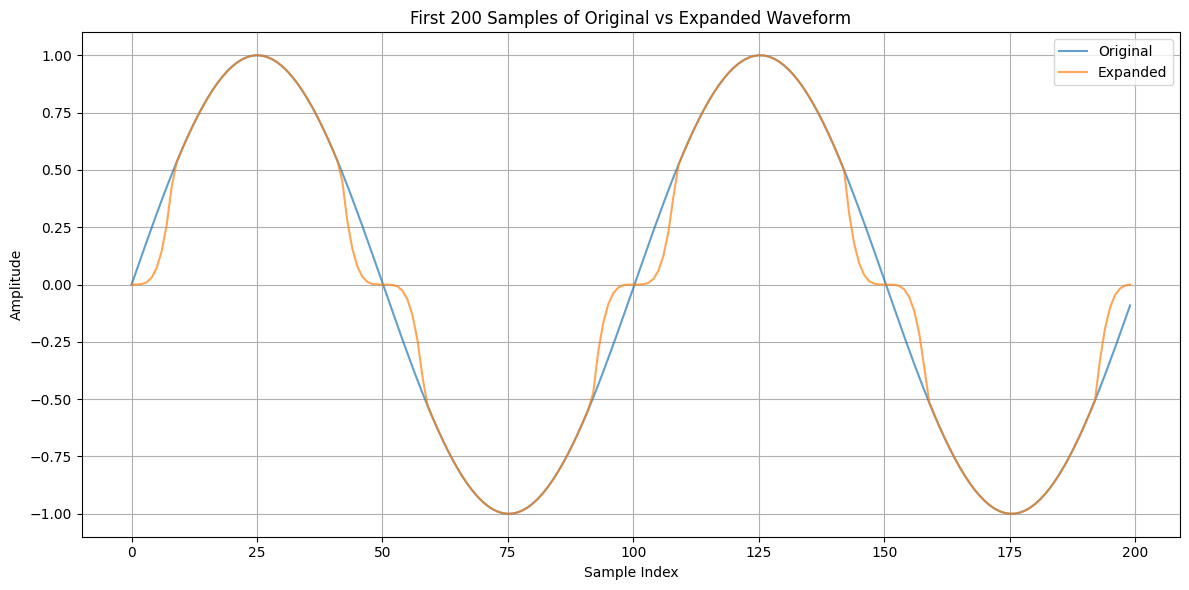

Expanded audio saved to Output/expanded_sine_wave.wav


In [3]:
# Apply expansion to the sine wave file
def apply_expansion(audio, threshold, ratio):
    """
    Apply dynamic range expansion to an audio signal.
    :param audio: Input audio signal (numpy array)
    :param threshold: Threshold level for expansion
    :param ratio: Expansion ratio
    :return: Expanded audio signal
    """
    expanded_audio = np.copy(audio)
    for i in range(len(audio)):
        if np.abs(audio[i]) < threshold:
            expanded_audio[i] = np.sign(audio[i]) * (
                (np.abs(audio[i]) / threshold) ** ratio * threshold
            )
    return expanded_audio
# Compression parameters
threshold = 0.5  # Threshold level (normalized)
ratio = 4.0      # Compression ratio
# Apply expansion
expanded_audio = apply_expansion(audio, threshold, ratio)

# Save the expanded audio to a new file
output_file_path = "Output/expanded_sine_wave.wav"
wav_write(output_file_path, sample_rate, (expanded_audio * 32767).astype(np.int16))

# Plot the first 200 samples of the original and expanded audio
plt.figure(figsize=(12, 6))
plt.plot(audio[:200], label="Original", alpha=0.7)
plt.plot(expanded_audio[:200], label="Expanded", alpha=0.7)
plt.title("First 200 Samples of Original vs Expanded Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Expanded audio saved to {output_file_path}")

Dynamic Range: 15.13 dB


/var/folders/b0/m80gf4wx3pvdbp860pz1fqwc0000gn/T/ipykernel_78613/166735784.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wav_read(file_path)
/var/folders/b0/m80gf4wx3pvdbp860pz1fqwc0000gn/T/ipykernel_78613/166735784.py:33: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wav_read(file_path)


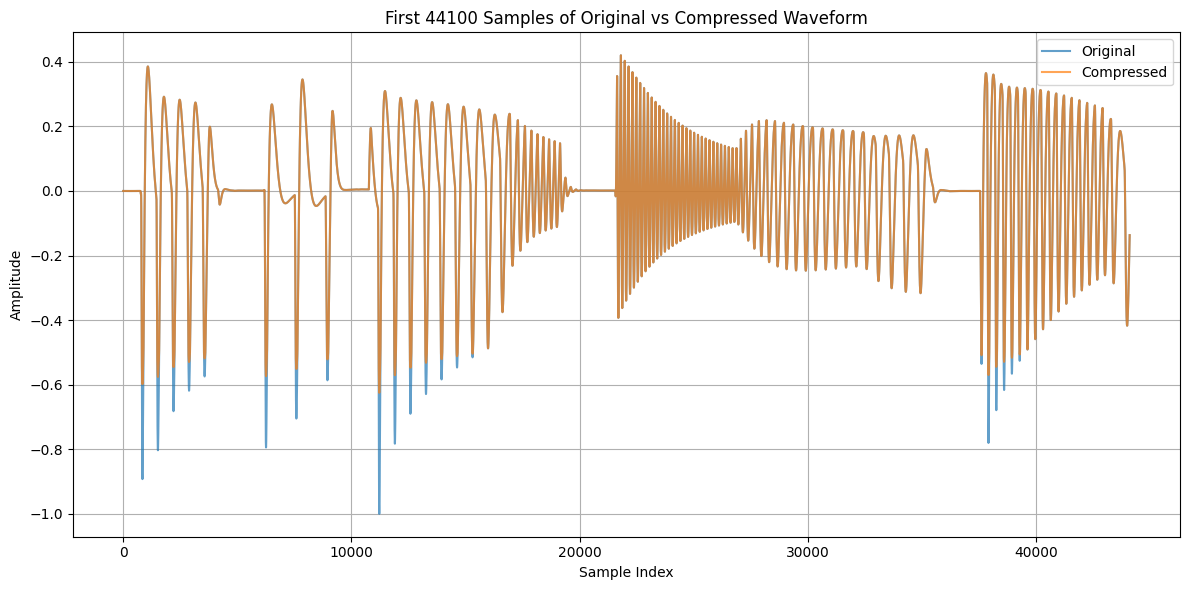

Compressed audio saved to Output/compressed_music.wav


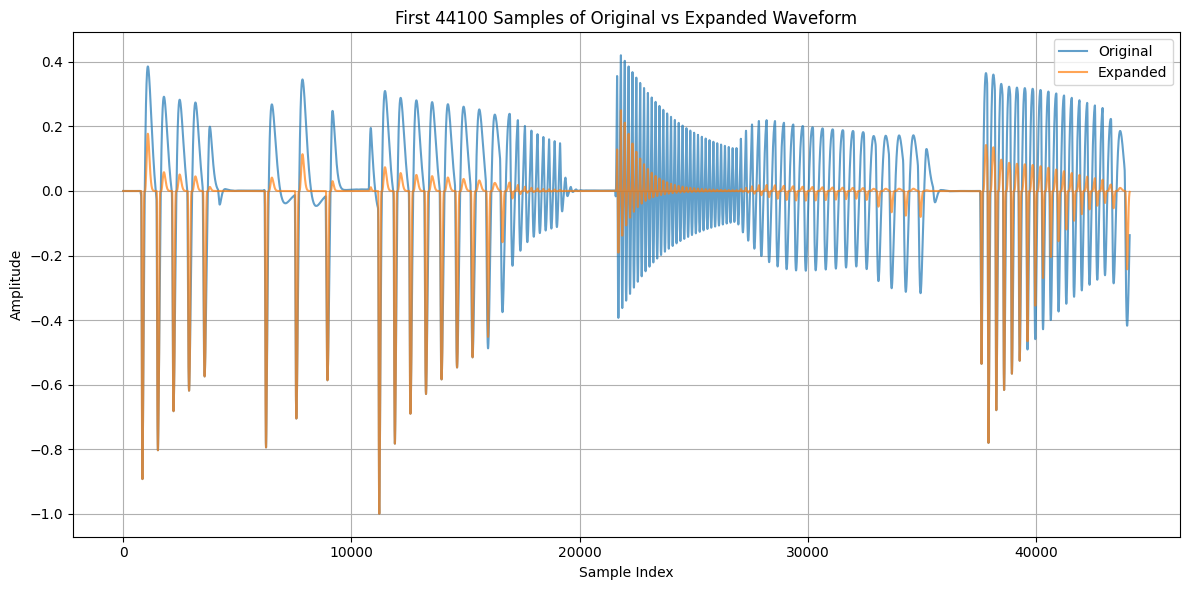

Expanded audio saved to Output/expanded_music.wav


In [4]:
# Compute the dynamic range of a music wav file, then compare waveforms after applying compression and expansion using the above functions
def compute_dynamic_range_music(file_path):
    # Load the audio file
    sample_rate, audio = wav_read(file_path)
    
    # If stereo, convert to mono
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    
    # Check for invalid values and handle them
    if np.any(np.isnan(audio)) or np.any(np.isinf(audio)):
        audio = np.nan_to_num(audio)  # Replace NaN/Inf with 0
    
    # Compute peak level
    peak_level = np.max(np.abs(audio))
    
    # Compute RMS level
    rms_level = np.sqrt(np.mean(audio**2))
    
    # Avoid division by zero
    if rms_level == 0:
        return float('-inf')  # Dynamic range is undefined if RMS is 0
    
    # Compute dynamic range in dB
    dynamic_range = 20 * np.log10(peak_level / rms_level)
    
    return dynamic_range
# Example usage
file_path = "Data/CTHS3_Acid_Bass_Loop_01_C_123.wav"
dynamic_range = compute_dynamic_range_music(file_path)
print(f"Dynamic Range: {dynamic_range:.2f} dB")
# Load the music file
sample_rate, audio = wav_read(file_path)
# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)
# Normalize the audio to range [-1, 1]
audio = audio / np.max(np.abs(audio))
# Compression parameters
threshold = 0.5  # Threshold level (normalized)
ratio = 4.0      # Compression ratio
# Apply compression
compressed_audio = apply_compression(audio, threshold, ratio)
# Save the compressed audio to a new file
output_file_path = "Output/compressed_music.wav"
wav_write(output_file_path, sample_rate, (compressed_audio * 32767).astype(np.int16))
# Plot the first 44100 samples of the original and compressed audio
plt.figure(figsize=(12, 6))     
plt.plot(audio[:44100], label="Original", alpha=0.7)
plt.plot(compressed_audio[:44100], label="Compressed", alpha=0.7)
plt.title("First 44100 Samples of Original vs Compressed Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
print(f"Compressed audio saved to {output_file_path}")
# Apply expansion to the music file 
# Compression parameters
threshold = 0.5  # Threshold level (normalized)
ratio = 4.0      # Compression ratio
# Apply expansion
expanded_audio = apply_expansion(audio, threshold, ratio)
# Save the expanded audio to a new file
output_file_path = "Output/expanded_music.wav"
wav_write(output_file_path, sample_rate, (expanded_audio * 32767).astype(np.int16))
# Plot the first 200 samples of the original and expanded audio
plt.figure(figsize=(12, 6))
plt.plot(audio[:44100], label="Original", alpha=0.7)
plt.plot(expanded_audio[:44100], label="Expanded", alpha=0.7)
plt.title("First 44100 Samples of Original vs Expanded Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
print(f"Expanded audio saved to {output_file_path}")


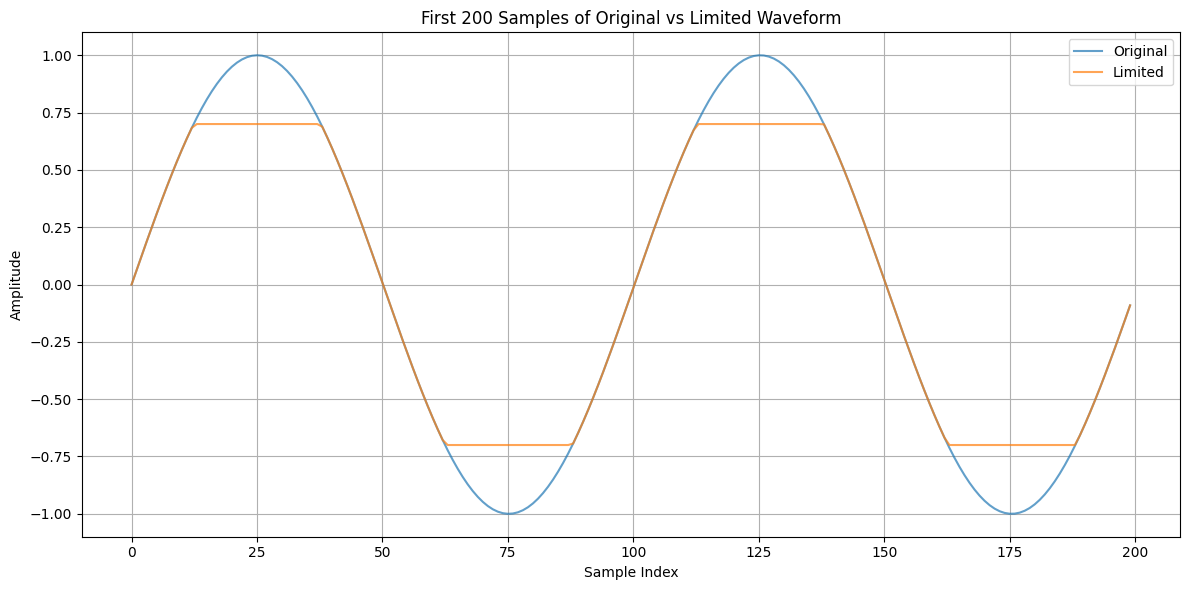

Limited audio saved to Output/limited_sine_wave.wav


In [5]:
import numpy as np
from scipy.io.wavfile import read as wav_read, write as wav_write
import matplotlib.pyplot as plt

def apply_limiting(audio, threshold):
    """
    Apply limiting to an audio signal.
    :param audio: Input audio signal (numpy array)
    :param threshold: Threshold level for limiting
    :return: Limited audio signal
    """
    limited_audio = np.copy(audio)
    limited_audio[limited_audio > threshold] = threshold
    limited_audio[limited_audio < -threshold] = -threshold
    return limited_audio

# Load the sine wave file
file_path = "Data/sine_wave_44100Hz_16bit_1min.wav"
sample_rate, audio = wav_read(file_path)

# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

# Normalize the audio to range [-1, 1]
audio = audio / np.max(np.abs(audio))

# Limiter parameters
threshold = 0.7  # Threshold level (normalized)

# Apply limiting
limited_audio = apply_limiting(audio, threshold)

# Save the limited audio to a new file
output_file_path = "Output/limited_sine_wave.wav"
wav_write(output_file_path, sample_rate, (limited_audio * 32767).astype(np.int16))

# Plot the original and limited waveforms
plt.figure(figsize=(12, 6))
plt.plot(audio[:200], label="Original", alpha=0.7)
plt.plot(limited_audio[:200], label="Limited", alpha=0.7)
plt.title("First 200 Samples of Original vs Limited Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Limited audio saved to {output_file_path}")

/var/folders/b0/m80gf4wx3pvdbp860pz1fqwc0000gn/T/ipykernel_78613/1560104200.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wav_read(file_path)


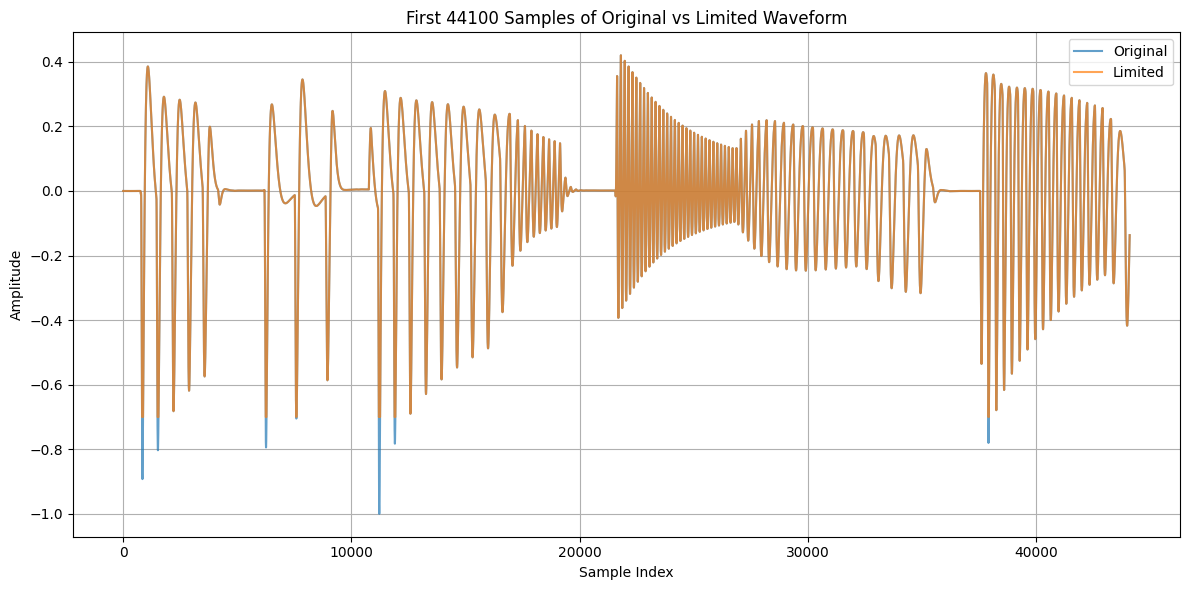

Limited audio saved to Output/limited_music.wav


In [6]:
import numpy as np
from scipy.io.wavfile import read as wav_read, write as wav_write
import matplotlib.pyplot as plt

def apply_limiting(audio, threshold):
    """
    Apply limiting to an audio signal.
    :param audio: Input audio signal (numpy array)
    :param threshold: Threshold level for limiting
    :return: Limited audio signal
    """
    limited_audio = np.copy(audio)
    limited_audio[limited_audio > threshold] = threshold
    limited_audio[limited_audio < -threshold] = -threshold
    return limited_audio

# Load the music file
file_path = "Data/CTHS3_Acid_Bass_Loop_01_C_123.wav"
sample_rate, audio = wav_read(file_path)

# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

# Normalize the audio to range [-1, 1]
audio = audio / np.max(np.abs(audio))

# Limiter parameters
threshold = 0.7  # Threshold level (normalized)

# Apply limiting
limited_audio = apply_limiting(audio, threshold)

# Save the limited audio to a new file
output_file_path = "Output/limited_music.wav"
wav_write(output_file_path, sample_rate, (limited_audio * 32767).astype(np.int16))

# Plot the first 44100 samples of the original and limited audio
plt.figure(figsize=(12, 6))
plt.plot(audio[:44100], label="Original", alpha=0.7)
plt.plot(limited_audio[:44100], label="Limited", alpha=0.7)
plt.title("First 44100 Samples of Original vs Limited Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Limited audio saved to {output_file_path}")

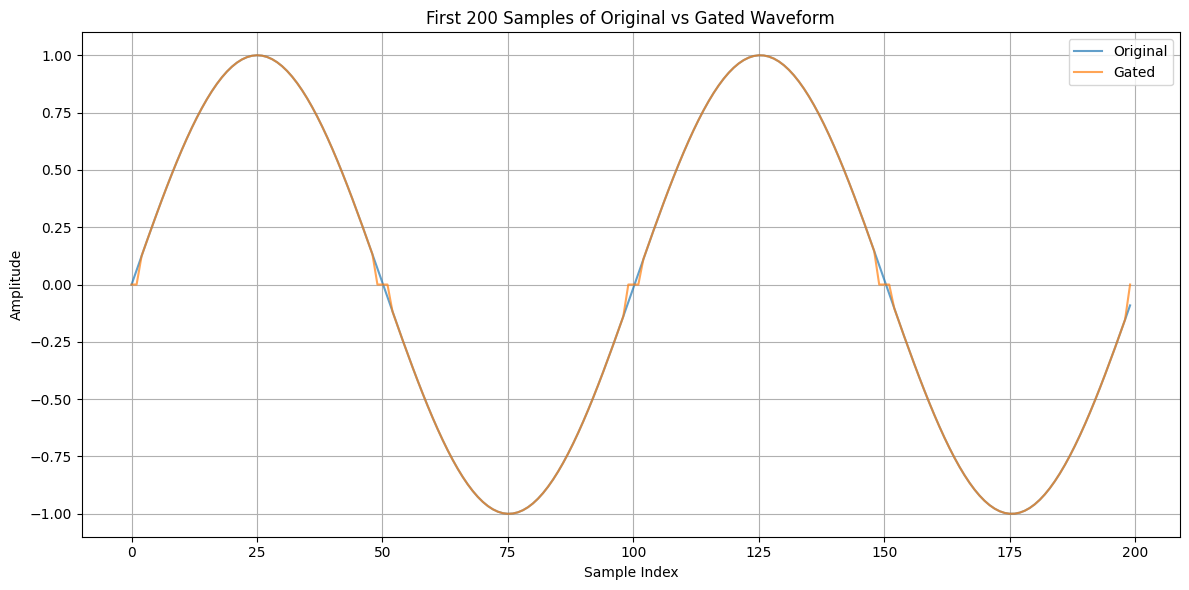

Gated audio saved to Output/gated_sine_wave.wav


In [7]:
# Apple gating to the sine wave file
def apply_gating(audio, threshold):
    """
    Apply gating to an audio signal.
    :param audio: Input audio signal (numpy array)
    :param threshold: Threshold level for gating
    :return: Gated audio signal
    """
    gated_audio = np.copy(audio)
    gated_audio[np.abs(audio) < threshold] = 0
    return gated_audio
# Load the sine wave file   
file_path = "Data/sine_wave_44100Hz_16bit_1min.wav"
sample_rate, audio = wav_read(file_path)
# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)
# Normalize the audio to range [-1, 1]  
audio = audio / np.max(np.abs(audio))
# Gating parameters
threshold = 0.1  # Threshold level (normalized)
# Apply gating
gated_audio = apply_gating(audio, threshold)        
# Save the gated audio to a new file
output_file_path = "Output/gated_sine_wave.wav"
wav_write(output_file_path, sample_rate, (gated_audio * 32767).astype(np.int16))
# Plot the original and gated waveforms
plt.figure(figsize=(12, 6))
plt.plot(audio[:200], label="Original", alpha=0.7)
plt.plot(gated_audio[:200], label="Gated", alpha=0.7)
plt.title("First 200 Samples of Original vs Gated Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
print(f"Gated audio saved to {output_file_path}")


/var/folders/b0/m80gf4wx3pvdbp860pz1fqwc0000gn/T/ipykernel_78613/3930522829.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wav_read(file_path)


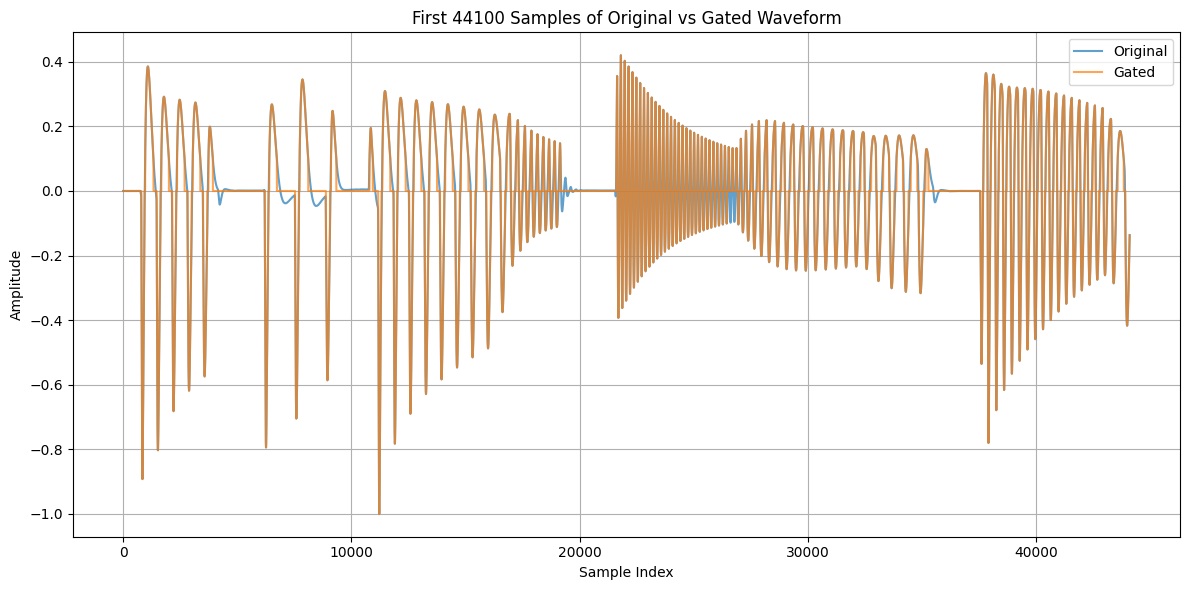

Gated audio saved to Output/gated_music.wav


In [8]:
# Apply gating to the music file
def apply_gating(audio, threshold):
    """
    Apply gating to an audio signal.
    :param audio: Input audio signal (numpy array)
    :param threshold: Threshold level for gating
    :return: Gated audio signal
    """
    gated_audio = np.copy(audio)
    gated_audio[np.abs(audio) < threshold] = 0
    return gated_audio
# Load the music file
file_path = "Data/CTHS3_Acid_Bass_Loop_01_C_123.wav"
sample_rate, audio = wav_read(file_path)
# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)
# Normalize the audio to range [-1, 1]
audio = audio / np.max(np.abs(audio))
# Gating parameters
threshold = 0.1  # Threshold level (normalized)
# Apply gating
gated_audio = apply_gating(audio, threshold)
# Save the gated audio to a new file
output_file_path = "Output/gated_music.wav"
wav_write(output_file_path, sample_rate, (gated_audio * 32767).astype(np.int16))
# Plot the first 44100 samples of the original and gated audio
plt.figure(figsize=(12, 6))
plt.plot(audio[:44100], label="Original", alpha=0.7)
plt.plot(gated_audio[:44100], label="Gated", alpha=0.7)
plt.title("First 44100 Samples of Original vs Gated Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
print(f"Gated audio saved to {output_file_path}")